<a href="https://colab.research.google.com/github/mk-armah/BECE-Grade-Analysis/blob/master/NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split

tf.random.set_seed(111)

In [235]:
! git clone https://github.com/mk-armah/BECE-Grade-Analysis

fatal: destination path 'BECE-Grade-Analysis' already exists and is not an empty directory.


In [236]:
os.chdir("/content/BECE-Grade-Analysis") 
os.getcwd()

'/content/BECE-Grade-Analysis'

In [237]:
df = pd.read_csv("cleaned_data_v2.xlsx")
df.head()

,Unnamed: 0,i_c_t,schtype,age,gender,circuit,c_record,mock,age_category
0,0,1,PRIVATE,15.0,M,SALTPOND B,38,85.0,regular
1,1,4,PRIVATE,15.0,F,SALTPOND B,36,67.0,regular
2,2,5,PUBLIC,19.0,M,MANKESSIM A,38,67.0,high school
3,3,2,PRIVATE,16.0,M,SALTPOND B,38,83.0,regular
4,4,6,PUBLIC,17.0,M,MDOMINASE,37,65.0,tertiary


In [238]:
df = df.drop(df.iloc[:,[0]].columns,axis = 1) #drop unnamed: 0 column

In [239]:
df.isna().sum()

i_c_t           0
schtype         0
age             0
gender          0
circuit         0
c_record        0
mock            0
age_category    0
dtype: int64

In [240]:
df.select_dtypes(['object']).columns

Index(['schtype', 'gender', 'circuit', 'age_category'], dtype='object')

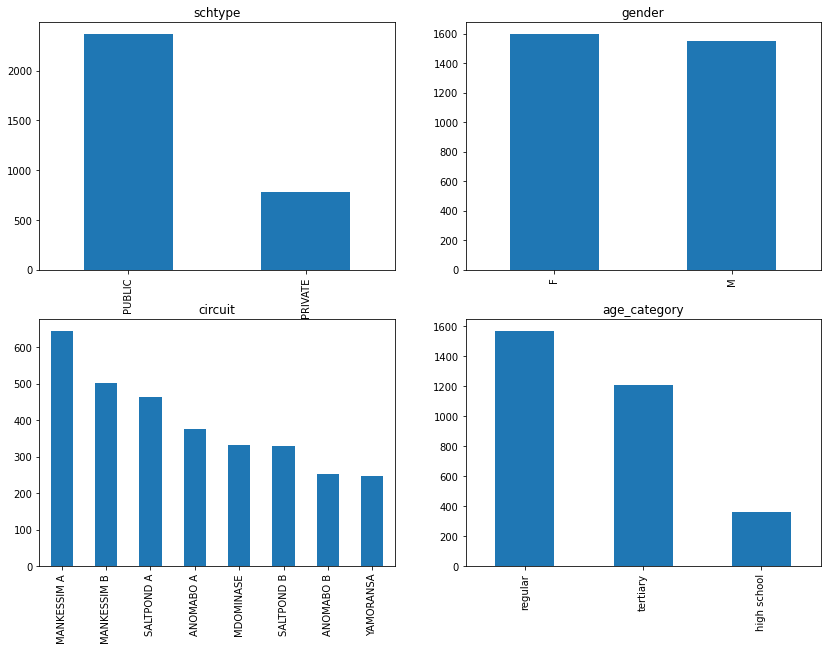

In [241]:
categories = df.select_dtypes(['object']).columns
plt.figure(figsize=(14,10))
for i in range(1,len(categories)+1):
  plt.subplot(2,2,i)
  df[categories[i-1]].value_counts().plot(kind = 'bar')
  plt.title(categories[i-1]);

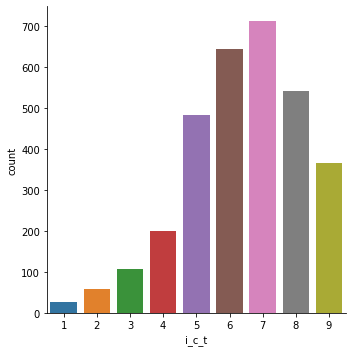

In [242]:
sns.catplot(x = 'i_c_t',data = df,kind = 'count') #class imbalance

In [243]:
def encoder(column):
  """convert categories to encodings"""
  data={}
  for enum,i in enumerate(list(df[column].value_counts().index)):
    data[i] = enum
  return data

In [244]:
for i in list(df.select_dtypes("O").columns):
  df[i] = df[i].map(encoder(i))

In [245]:
df.head()

,i_c_t,schtype,age,gender,circuit,c_record,mock,age_category
0,1,1,15.0,1,5,38,85.0,0
1,4,1,15.0,0,5,36,67.0,0
2,5,0,19.0,1,0,38,67.0,2
3,2,1,16.0,1,5,38,83.0,0
4,6,0,17.0,1,4,37,65.0,1


In [246]:
def data_splitter(scale = True):
  """split the data into training and validation split
  scale: if True the training and testing data will be scaled using x' = (x - μ) / σ
  where x is a datapoint of the column to be scaled, μ is the mean and σ is the standard deviation"""
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 111,stratify = y)

  if scale:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

  return X_train, X_test, y_train, y_test

In [247]:
bins = pd.IntervalIndex.from_tuples([(0, 6), (6,9)])
ict = pd.cut(df['i_c_t'],bins = bins,labels = ['Pass','Fail'])
df['ict'] = ict

In [248]:
# "convert the ict interval into string categorical"
# try:
#         assert df['ict'].isin(['pass','average','fail']).any() == True
#         print("already exists")

# except Exception as e:

#         df['ict'] = df.ict.astype('str').map(
#                 {'(0, 3]':'Pass',
#                 '(3, 6]':'Average',
#                 '(6, 9]':'Fail'}
#         )



# df['ict'] = df['ict'].astype(pd.CategoricalDtype())

"convert the ict interval into string categorical"
try:
        assert df['ict'].isin(['Pass','Fail']).any() == True
        print("already exists")

except Exception as e:

        df['ict'] = df.ict.astype('str').map(
                {'(0, 6]':'Pass',
                '(6, 9]':'Fail'}
        )



df['ict'] = df['ict'].astype(pd.CategoricalDtype())

In [249]:
df = df.drop(columns = ['i_c_t','age'])
df.head()

,schtype,gender,circuit,c_record,mock,age_category,ict
0,1,1,5,38,85.0,0,Pass
1,1,0,5,36,67.0,0,Pass
2,0,1,0,38,67.0,2,Pass
3,1,1,5,38,83.0,0,Pass
4,0,1,4,37,65.0,1,Pass


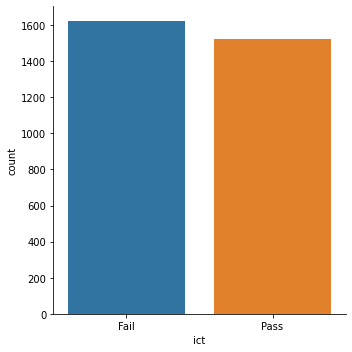

In [250]:
sns.catplot(x = 'ict',data = df,kind = 'count')

In [253]:
X  = df.iloc[:,df.columns!='ict']
y = df.iloc[:,df.columns=='ict'] #.astype("float32")
# y = y['ict'].map({'Fail':0,'Average':1,'Pass':2}).astype('flaot')
y = y['ict'].map({'Fail':0,'Pass':1}).astype('float')
y

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3138    0.0
3139    0.0
3140    0.0
3141    0.0
3142    0.0
Name: ict, Length: 3143, dtype: float64

In [254]:
y = tf.keras.utils.to_categorical(y) #convert y to one-hot-encodings

In [255]:
X.head()

,schtype,gender,circuit,c_record,mock,age_category
0,1,1,5,38,85.0,0
1,1,0,5,36,67.0,0
2,0,1,0,38,67.0,2
3,1,1,5,38,83.0,0
4,0,1,4,37,65.0,1


In [256]:
X_train, X_test, y_train, y_test = data_splitter(scale = True)

In [257]:
print("shape of X",((X_train.size/X.size)*100),"%")
print("shape of X",((X_test.size/X.size)*100),"%")

shape of X 79.98727330575883 %
shape of X 20.01272669424117 %


In [258]:
class NeuralNet(tf.keras.Model):
  def __init__(self,out_layer,in_layers = [32,64,128]):
    super(NeuralNet,self).__init__()
    self.in_layers = in_layers
    self.out_layer = out_layer
    
    self.first_layer = tf.keras.layers.Dense(self.in_layers[0],name = "first_layer",activation = 'relu',input_shape = (6,))
   # self.dropout = tf.keras.layers.Dropout(0.2,name = 'dropout')
    self.second_layer  = tf.keras.layers.Dense(self.in_layers[1],name = "second_layer",activation = 'relu')
    self.third_layer = tf.keras.layers.Dense(self.in_layers[2],name = "third_layer",activation = 'relu')
    self.last_layer = tf.keras.layers.Dense(self.out_layer,name = "last_layer",activation="softmax")

  def call(self,x):
    x = self.first_layer(x)
    x = self.second_layer(x)
    #x = self.dropout = self.dropout(x)
    x = self.third_layer(x)
    output = self.last_layer(x)
    return output

In [259]:
model = NeuralNet(out_layer = 2)

In [269]:
model.compile(optimizer='adam', # use adaptive momentum
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              
# Train the Model
tf.keras.backend.clear_session()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs= 7) #training for 500 epochs

Epoch 1/7
79/79 [==============================] - 1s 6ms/step - loss: 0.2441 - accuracy: 0.8850 - val_loss: 0.4797 - val_accuracy: 0.7981
Epoch 2/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.8898 - val_loss: 0.4602 - val_accuracy: 0.8029
Epoch 3/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2357 - accuracy: 0.8898 - val_loss: 0.4704 - val_accuracy: 0.7997
Epoch 4/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2342 - accuracy: 0.8819 - val_loss: 0.4739 - val_accuracy: 0.7981
Epoch 5/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2336 - accuracy: 0.8799 - val_loss: 0.4761 - val_accuracy: 0.8045
Epoch 6/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.8918 - val_loss: 0.4717 - val_accuracy: 0.7901
Epoch 7/7
79/79 [==============================] - 0s 3ms/step - loss: 0.2310 - accuracy: 0.8902 - val_loss: 0.4860 - val_accuracy: 0.8076


In [264]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


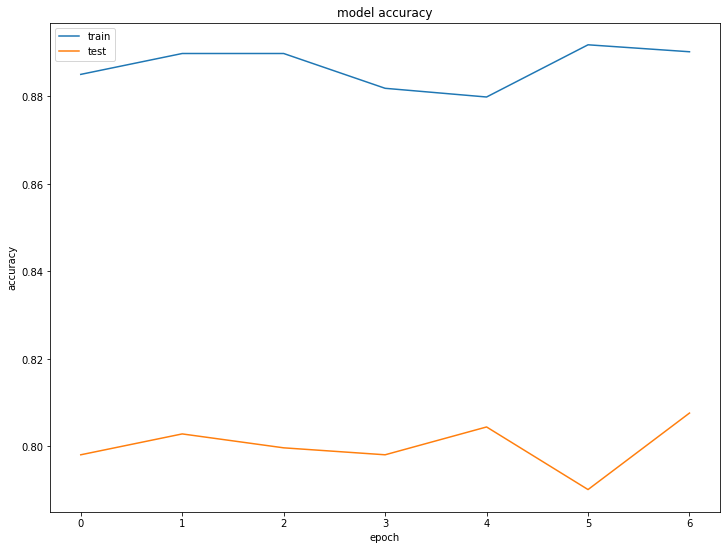

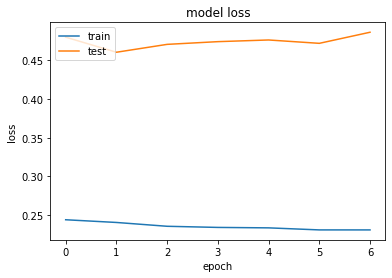

In [270]:
# summarize history for accuracy
plt.figure(figsize = (12,9))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()